In [1]:
!pip install scanpy
!pip install muon

In [2]:
import scanpy as sc
import muon as mu
import pandas as pd
import numpy as np
import scipy as sp
import anndata as ad
import seaborn as sns

In [3]:
clone_matrix = sp.io.mmread('stateFate_inVitro_clone_matrix.mtx')
x = sp.io.mmread('stateFate_inVitro_normed_counts.mtx').tocsr()

In [4]:
cell_data = pd.read_csv('stateFate_inVitro_metadata.txt', sep='\t')
genes = pd.read_csv('stateFate_inVitro_gene_names.txt', names = ["Gene_names"])
genes.index = genes.index.astype(str)

In [5]:
clone_data = pd.DataFrame.sparse.from_spmatrix(clone_matrix)
cell_data_full = pd.concat([cell_data, clone_data], axis=1)
cell_data_full.index = cell_data_full.index.astype(str)

In [6]:
A_Data = ad.AnnData(
    X = x,
    obs = cell_data_full,
    var = genes
)

In [7]:
A_Data_day_2 = A_Data[A_Data.obs['Time point'] == 2.0, : ].copy()

In [8]:
A_Data_day_2.obs.groupby(['Starting population']).size()

Starting population
Lin-Kit+Sca1+    20456
Lin-Kit+Sca1-     7793
dtype: int64

In [9]:
def get_clone_family_size(data):
    res = {"Clone family" : [], "Member count" : []}
    for column_name in data.obs:
        if type(column_name) == int:
            count = (data.obs[column_name] == 1).sum()
            if count >= 2:
                res["Clone family"].append(column_name)
                res["Member count"].append(count)
    return res

In [10]:
clone_family_size_up2_dict = get_clone_family_size(A_Data_day_2)
clone_family_size_up2_df = pd.DataFrame(clone_family_size_up2_dict) 
clone_family_size_up2_df.sort_values(by = "Member count", ascending = False) 
## When working with the X as sparse matrix we got back to indexing from 0 - Clone family 0 = Clone family 1 in original file

,Clone family,Member count
444,1949,8
556,2414,7
1121,4819,6
986,4214,6
984,4211,6
...,...,...
553,2396,2
550,2388,2
548,2382,2
547,2375,2


3367


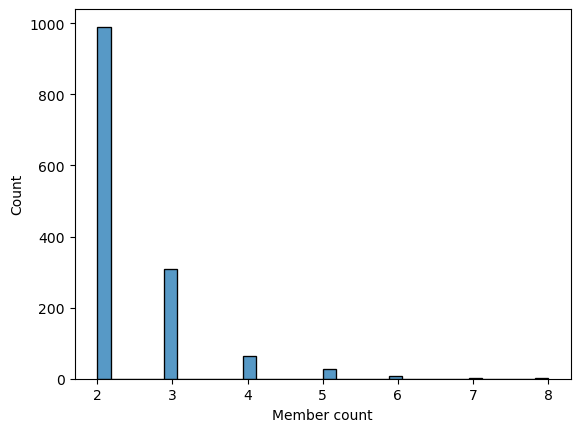

In [11]:
sns.histplot(data = clone_family_size_up2_df, x = "Member count")
print(sum(clone_family_size_up2_dict['Member count']))

In [12]:
def get_clone_family(data, clone_family):
    return data[list(data.obs[clone_family] == 1), :]

In [13]:
test = get_clone_family(A_Data_day_2, 2414)
test.obs

,Library,Cell barcode,Time point,Starting population,Cell type annotation,Well,SPRING-x,SPRING-y,0,1,...,5854,5855,5856,5857,5858,5859,5860,5861,5862,5863
15597,d2_3,TAGCGGAT-TCATCCTT,2.0,Lin-Kit+Sca1-,Undifferentiated,0,202.712,-50.938,0,0,...,0,0,0,0,0,0,0,0,0,0
16275,d2_2,GGTTGAGA-ATACTCTT,2.0,Lin-Kit+Sca1-,Undifferentiated,0,245.966,-163.533,0,0,...,0,0,0,0,0,0,0,0,0,0
17124,d2_2,CTCCTCCA-ATCAAGTG,2.0,Lin-Kit+Sca1-,Undifferentiated,0,295.632,-229.173,0,0,...,0,0,0,0,0,0,0,0,0,0
17386,d2_2,GTCAGACC-AATCGGGT,2.0,Lin-Kit+Sca1-,Undifferentiated,0,335.611,-172.034,0,0,...,0,0,0,0,0,0,0,0,0,0
17533,d2_2,AGCTTCGA-GTTTACGT,2.0,Lin-Kit+Sca1-,Undifferentiated,0,263.440,-123.486,0,0,...,0,0,0,0,0,0,0,0,0,0
18221,d2_2,GGGTCATT-TGGCCTGT,2.0,Lin-Kit+Sca1-,Undifferentiated,0,297.885,-98.005,0,0,...,0,0,0,0,0,0,0,0,0,0
18933,d2_1,TAATGTGG-CTCGATGC,2.0,Lin-Kit+Sca1-,Undifferentiated,0,330.327,74.507,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
def get_adequate_clones(data):
    up2_families = clone_family_size_up2_dict['Clone family']
    mask = np.zeros(data.shape[0], dtype=bool)
    
    for i, clone_family in enumerate(up2_families):
        if i % 100 == 0:
            print(str(i) + "/" + str(len(up2_families)))
        current_membership = (data.obs[clone_family] == 1).astype(bool).tolist()
        mask |= current_membership

    return data[mask].copy()
    
    

In [15]:
A_Data_day_2_up2 = get_adequate_clones(A_Data_day_2) ## Yippeeee we have same about of rows as the sum of all members in the clone families up2 histogram. 

0/1401
100/1401
200/1401
300/1401
400/1401
500/1401
600/1401
700/1401
800/1401
900/1401
1000/1401
1100/1401
1200/1401
1300/1401
1400/1401


In [16]:
A_Data_day_2_up2.shape

(3367, 25289)

In [18]:
del A_Data
del A_Data_day_2_up2
del x
del cell_data_full
del cell_data
del genes

NameError: name 'A_Data' is not defined